# ECON7890 Assignment 4 ? Kowloon Property Transactions

End-to-end notebook: import/clean the 28hse Kowloon transactions (Nov 2014?Nov 2020), merge macro data, explore, model price drivers, and summarize findings.

**Tasks**
- Import & clean the raw CSV, fix headers, parse numbers, handle missing values
- Merge with external macro indicators (World Bank unemployment & CPI)
- Exploratory data analysis with descriptive stats and visuals
- Train/evaluate multiple models to explain price per saleable sqft
- Summarize insights and next steps


In [1]:
import re
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

NOTEBOOK_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
DATA_PATH = NOTEBOOK_DIR / 'hw.csv'
OUTPUT_DIR = NOTEBOOK_DIR / 'assignment4_outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


## 1) Load raw data
Read the provided `hw.csv` file and inspect the columns.


In [2]:
raw_df = pd.read_csv(DATA_PATH)
display(raw_df.head())
print(f"Rows: {len(raw_df):,}, Columns: {len(raw_df.columns)}")
raw_df.columns.tolist()

,date,withpre,id,rootid,fatherid,catid,catname,catfathername,url_father,url_cat,...,month,day,date_dm,date_y,block,state,floor,room,addr,Unnamed: 34
0,2020-11-27,1.0,683333,2,79,2058,Bel Air Heights,Diamond Hill,https://data.28hse.com/en/kl/diamond-hill,https://data.28hse.com/en/kl/diamond-hill/2058...,...,Nov,27,27/11,2020,BLOCK 2,NaN,2#,E,BLOCK 2 2#/F Room E,NaN
1,2020-11-27,1.0,683332,2,71,2712,Fa Yuen Plaza,Mong Kok,https://data.28hse.com/en/kl/mong-kok,https://data.28hse.com/en/kl/mong-kok/2712_fa-...,...,Nov,27,27/11,2020,NaN,NaN,1#,C,1#/F Room C,NaN
2,2020-11-27,1.0,683331,2,78,3094,Caldecott Hill,Yau Yat Tsuen,https://data.28hse.com/en/kl/yau-yat-tsuen,https://data.28hse.com/en/kl/yau-yat-tsuen/309...,...,Nov,27,27/11,2020,TOWER 1,NaN,7,E,TOWER 1 7/F Room E,NaN
3,2020-11-27,NaN,683330,2,57,5035,Pang Ching Court,Wong Tai Sin,https://data.28hse.com/en/kl/wong-tai-sin,https://data.28hse.com/en/kl/wong-tai-sin/5035...,...,Nov,27,27/11,2020,NaN,NaN,1#,22,1#/F Room 22,NaN
4,2020-11-27,1.0,683329,2,67,2564,Metro Harbour View,Tai Kok Tsui,https://data.28hse.com/en/kl/tai-kok-tsui,https://data.28hse.com/en/kl/tai-kok-tsui/2564...,...,Nov,27,27/11,2020,BLOCK 8,NaN,1#,B,BLOCK 8 1#/F Room B,NaN


Rows: 80,000, Columns: 35


['date',
 'withpre',
 'id',
 'rootid',
 'fatherid',
 'catid',
 'catname',
 'catfathername',
 'url_father',
 'url_cat',
 'source',
 'contract',
 'memo',
 'price',
 'price_value',
 'holddate',
 'winloss_flag',
 'winloss',
 'act_area',
 'area',
 'arearaw',
 'sq_price',
 'sq_price_value',
 'sq_actprice',
 'sq_actprice_value',
 'month',
 'day',
 'date_dm',
 'date_y',
 'block',
 'state',
 'floor',
 'room',
 'addr',
 'Unnamed: 34']

## 2) Cleaning helpers
The raw headers are cryptic and some fields embed units/HTML. Helper functions below parse numbers, percentages, and holding periods.


In [3]:
def _parse_number(text: Any) -> float:
    # Extract first numeric value from a string; return NaN on failure.
    if pd.isna(text):
        return np.nan
    match = re.search(r"([0-9]*\.?[0-9]+)", str(text))
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            return np.nan
    return np.nan


def _parse_percent(text: Any) -> float:
    # Convert percent strings (e.g., '413%') to decimal (4.13).
    if pd.isna(text):
        return np.nan
    text = str(text).replace('%', '').strip()
    if not text or text == '--':
        return np.nan
    try:
        return float(text) / 100.0
    except ValueError:
        return np.nan


def _parse_holding_years(text: Any) -> float:
    # Convert holding period text such as '16 years 251 days' into years.
    if pd.isna(text):
        return np.nan
    if text in ('--', '-1'):
        return np.nan
    text = str(text)
    years = _parse_number(text)
    days_match = re.search(r"([0-9]+)\s*day", text)
    days = float(days_match.group(1)) if days_match else 0.0
    if np.isnan(years):
        return days / 365.0 if days else np.nan
    return years + days / 365.0

## 3) Clean transactions
- Drop unnamed columns
- Rename to readable headers
- Parse dates, numbers, areas, floor, holding period, win/loss
- Remove bad rows and duplicates


In [4]:
def clean_transactions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df = df.drop(columns=[c for c in df.columns if c.startswith('Unnamed')], errors='ignore')
    rename_map: Dict[str, str] = {
        'withpre': 'pre_sale_flag',
        'catname': 'estate',
        'catfathername': 'district',
        'price': 'price_label',
        'price_value': 'price_hkd',
        'holddate': 'holding_period_text',
        'winloss': 'winloss_pct',
        'act_area': 'saleable_area',
        'area': 'gross_area',
        'arearaw': 'gross_area_raw',
        'sq_price': 'sq_price_label',
        'sq_price_value': 'price_per_gross_sf',
        'sq_actprice': 'sq_actprice_label',
        'sq_actprice_value': 'price_per_saleable_sf',
        'date_y': 'year_text',
        'state': 'building',
        'addr': 'address',
    }
    df = df.rename(columns=rename_map)

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['pre_sale_flag'] = df['pre_sale_flag'].fillna(0).astype(int)
    df['price_hkd'] = pd.to_numeric(df['price_hkd'], errors='coerce')
    df['price_per_gross_sf'] = pd.to_numeric(df['price_per_gross_sf'], errors='coerce')
    df['price_per_saleable_sf'] = pd.to_numeric(df['price_per_saleable_sf'], errors='coerce')

    df['saleable_area'] = df['saleable_area'].apply(_parse_number)
    df['gross_area'] = df['gross_area'].apply(_parse_number)
    gross_series = df['gross_area_raw'] if 'gross_area_raw' in df.columns else pd.Series(np.nan, index=df.index)
    df['gross_area_raw'] = pd.to_numeric(gross_series, errors='coerce')

    df['floor_num'] = df['floor'].apply(_parse_number)
    df['holding_period_years'] = df['holding_period_text'].apply(_parse_holding_years)
    df['winloss_pct'] = df['winloss_pct'].apply(_parse_percent)

    df['price_per_saleable_sf'] = df['price_per_saleable_sf'].fillna(
        df['price_hkd'] / df['saleable_area']
    )

    df = df.dropna(subset=['date', 'price_hkd', 'saleable_area', 'price_per_saleable_sf', 'district', 'estate'])
    df = df[(df['saleable_area'] > 0) & (df['price_hkd'] > 0) & (df['price_per_saleable_sf'] > 0)]

    df['estate'] = df['estate'].astype(str).str.strip()
    df['district'] = df['district'].astype(str).str.strip()
    df['building'] = df['building'].astype(str).str.strip()

    if 'id' in df.columns:
        df = df.drop_duplicates(subset=['id'])

    return df


cleaned_df = clean_transactions(raw_df)
display(cleaned_df.head())
print(f"Cleaned rows: {len(cleaned_df):,}")
cleaned_df.to_csv(OUTPUT_DIR / 'cleaned_transactions.csv', index=False)

,date,pre_sale_flag,id,rootid,fatherid,catid,estate,district,url_father,url_cat,...,date_dm,year_text,block,building,floor,room,address,year,floor_num,holding_period_years
0,2020-11-27,1,683333,2,79,2058,Bel Air Heights,Diamond Hill,https://data.28hse.com/en/kl/diamond-hill,https://data.28hse.com/en/kl/diamond-hill/2058...,...,27/11,2020,BLOCK 2,nan,2#,E,BLOCK 2 2#/F Room E,2020,2.0,16.687671
1,2020-11-27,1,683332,2,71,2712,Fa Yuen Plaza,Mong Kok,https://data.28hse.com/en/kl/mong-kok,https://data.28hse.com/en/kl/mong-kok/2712_fa-...,...,27/11,2020,NaN,nan,1#,C,1#/F Room C,2020,1.0,2.958904
2,2020-11-27,1,683331,2,78,3094,Caldecott Hill,Yau Yat Tsuen,https://data.28hse.com/en/kl/yau-yat-tsuen,https://data.28hse.com/en/kl/yau-yat-tsuen/309...,...,27/11,2020,TOWER 1,nan,7,E,TOWER 1 7/F Room E,2020,7.0,5.600000
4,2020-11-27,1,683329,2,67,2564,Metro Harbour View,Tai Kok Tsui,https://data.28hse.com/en/kl/tai-kok-tsui,https://data.28hse.com/en/kl/tai-kok-tsui/2564...,...,27/11,2020,BLOCK 8,nan,1#,B,BLOCK 8 1#/F Room B,2020,1.0,12.430137
5,2020-11-27,1,683328,2,65,2521,Nob Hill,Mei Foo,https://data.28hse.com/en/kl/mei-foo,https://data.28hse.com/en/kl/mei-foo/2521_nob-...,...,27/11,2020,TOWER 1,nan,1#,F,TOWER 1 1#/F Room F,2020,1.0,14.027397


Cleaned rows: 38,257


## 4) Macro data (World Bank)
Pull Hong Kong unemployment rate (`SL.UEM.TOTL.ZS`) and CPI (`FP.CPI.TOTL`, 2010=100) and merge by year.


In [5]:
def fetch_world_bank_indicator(indicator_id: str, value_name: str, start_year: int = 2014, end_year: int = 2020) -> pd.DataFrame:
    url = f"https://api.worldbank.org/v2/country/HKG/indicator/{indicator_id}?per_page=500&format=json"
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    data = resp.json()
    if len(data) < 2 or not isinstance(data[1], list):
        raise ValueError(f"Unexpected World Bank response for {indicator_id}")
    records: List[Dict[str, float]] = []
    for entry in data[1]:
        year_txt = entry.get('date')
        value = entry.get('value')
        if value is None or year_txt is None:
            continue
        try:
            year = int(year_txt)
        except ValueError:
            continue
        if start_year <= year <= end_year:
            records.append({'year': year, value_name: float(value)})
    out = pd.DataFrame(records).sort_values('year').reset_index(drop=True)
    return out


def build_macro_dataset(start_year: int = 2014, end_year: int = 2020) -> pd.DataFrame:
    unemployment = fetch_world_bank_indicator('SL.UEM.TOTL.ZS', 'unemployment_rate', start_year, end_year)
    cpi = fetch_world_bank_indicator('FP.CPI.TOTL', 'cpi_index', start_year, end_year)
    return pd.merge(unemployment, cpi, on='year', how='outer')


macro_df = build_macro_dataset(2014, 2020)
display(macro_df)
macro_df.to_csv(OUTPUT_DIR / 'macro_data.csv', index=False)

,year,unemployment_rate,cpi_index
0,2014,3.296,119.384997
1,2015,3.314,122.955621
2,2016,3.392,125.918000
3,2017,3.124,127.799054
4,2018,2.805,130.874071
5,2019,2.917,134.647443
6,2020,5.808,134.985357


## 5) Merge transactions + macro
Merge on year to enrich each transaction with unemployment/CPI.


In [6]:
merged_df = pd.merge(cleaned_df, macro_df, on='year', how='left')
display(merged_df[['date', 'district', 'price_hkd', 'saleable_area', 'price_per_saleable_sf', 'unemployment_rate', 'cpi_index']].head())
merged_df.to_csv(OUTPUT_DIR / 'transactions_with_macro.csv', index=False)

,date,district,price_hkd,saleable_area,price_per_saleable_sf,unemployment_rate,cpi_index
0,2020-11-27,Diamond Hill,10000000,657.0,15220.70,5.808,134.985357
1,2020-11-27,Mong Kok,4280000,214.0,20000.00,5.808,134.985357
2,2020-11-27,Yau Yat Tsuen,11000000,991.0,11099.90,5.808,134.985357
3,2020-11-27,Tai Kok Tsui,7150000,412.0,17354.37,5.808,134.985357
4,2020-11-27,Mei Foo,2460000,457.0,5382.93,5.808,134.985357


## 6) Exploratory Data Analysis
- Summary stats & missing values
- Top districts by count
- Distribution and scatter plots
- Monthly median price trend and yearly macro overlay


,price_hkd,saleable_area,gross_area,price_per_saleable_sf,price_per_gross_sf
count,3.825700e+04,38257.000000,25191.000000,38257.000000,38257.000000
mean,9.146396e+06,537.478658,729.950736,16146.472138,7467.315900
std,9.317771e+06,275.987299,301.597647,5506.599411,6094.495547
min,1.375000e+05,152.000000,238.000000,352.560000,0.000000
25%,5.128000e+06,372.000000,550.000000,12949.640000,0.000000
50%,7.000000e+06,496.000000,663.000000,15618.450000,9288.890000
75%,9.776400e+06,612.000000,823.000000,18459.570000,11996.780000
max,4.238000e+08,4414.000000,6168.000000,104418.100000,79324.590000


gross_area               13066
price_hkd                    0
saleable_area                0
price_per_saleable_sf        0
price_per_gross_sf           0
dtype: int64

district
Hung Hom          4453
Ho Man Tin        3573
To Kwa Wan        2794
Olympic           2680
Kowloon Bay       2666
Cheung Sha Wan    2424
Lam Tin           2398
Mei Foo           2299
Lai Chi Kok       2179
Tai Kok Tsui      1765
Name: count, dtype: int64

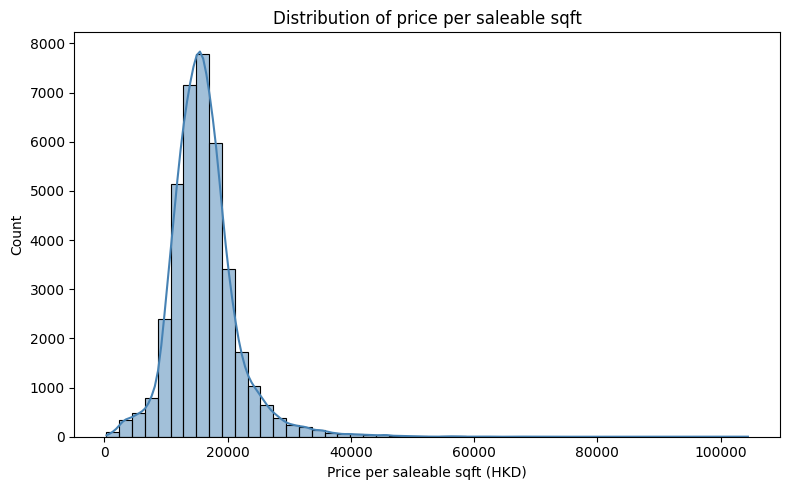

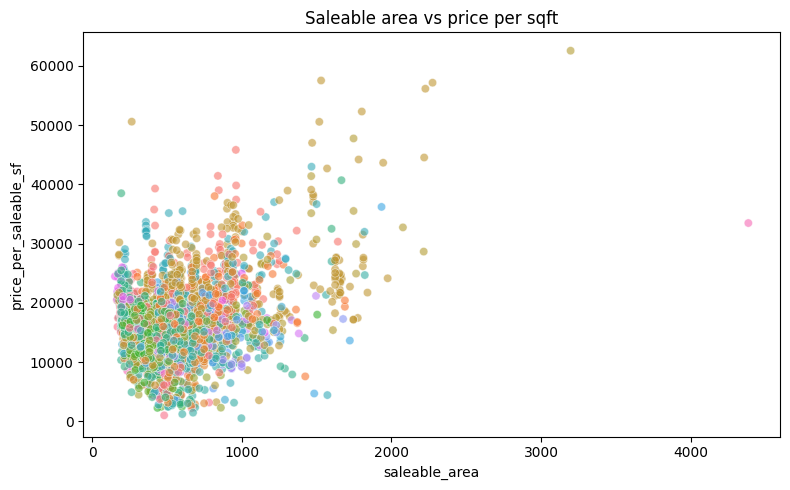

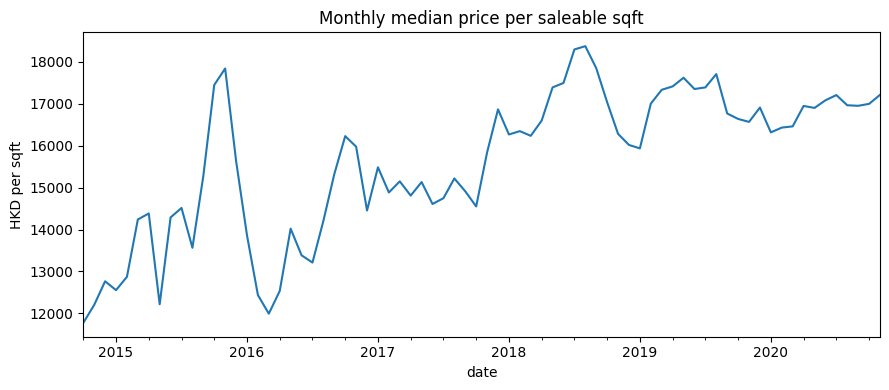

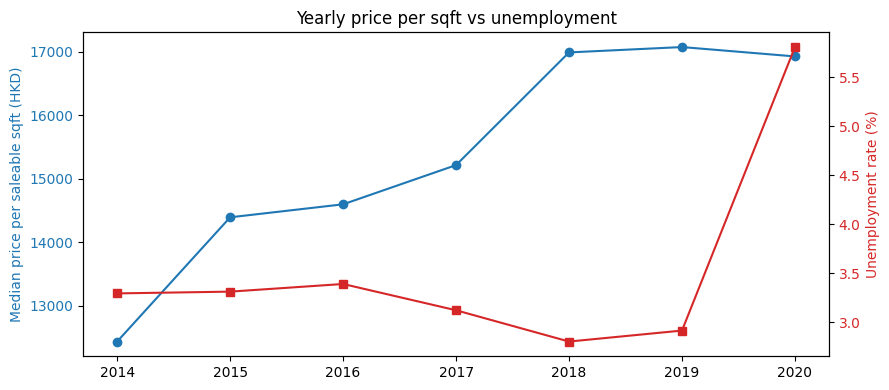

In [7]:
numeric_cols = ['price_hkd', 'saleable_area', 'gross_area', 'price_per_saleable_sf', 'price_per_gross_sf']
summary_stats = merged_df[numeric_cols].describe()
missing = merged_df[numeric_cols].isna().sum().sort_values(ascending=False)
top_districts = merged_df['district'].value_counts().head(10)

display(summary_stats)
display(missing)
display(top_districts)

plt.figure(figsize=(8, 5))
sns.histplot(x=merged_df['price_per_saleable_sf'], bins=50, kde=True, color='steelblue')
plt.xlabel('Price per saleable sqft (HKD)')
plt.title('Distribution of price per saleable sqft')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=merged_df.sample(min(len(merged_df), 5000), random_state=42),
    x='saleable_area', y='price_per_saleable_sf', hue='district', alpha=0.6, legend=False
)
plt.title('Saleable area vs price per sqft')
plt.tight_layout()
plt.show()

monthly = merged_df.set_index('date')['price_per_saleable_sf'].resample('ME').median().dropna()
monthly.plot(figsize=(9, 4), title='Monthly median price per saleable sqft')
plt.ylabel('HKD per sqft')
plt.tight_layout()
plt.show()

yearly = (
    merged_df.groupby('year')
    .agg(median_price_per_saleable_sf=('price_per_saleable_sf', 'median'), unemployment_rate=('unemployment_rate', 'median'))
    .dropna()
)
if not yearly.empty:
    fig, ax1 = plt.subplots(figsize=(9, 4))
    ax1.plot(yearly.index, yearly['median_price_per_saleable_sf'], marker='o', color='tab:blue', label='Median price/sf')
    ax1.set_ylabel('Median price per saleable sqft (HKD)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(yearly.index, yearly['unemployment_rate'], marker='s', color='tab:red', label='Unemployment rate')
    ax2.set_ylabel('Unemployment rate (%)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Yearly price per sqft vs unemployment')
    fig.tight_layout()
    plt.show()

## 7) Modeling price per saleable sqft
Two models: linear regression (baseline) and random forest. Features include size, floor, holding period, win/loss, macro indicators, and district (one-hot).


In [8]:
target = 'price_per_saleable_sf'
feature_columns = [
    'saleable_area', 'gross_area', 'floor_num', 'holding_period_years', 'winloss_pct',
    'pre_sale_flag', 'unemployment_rate', 'cpi_index', 'year', 'district'
]

model_df = merged_df.dropna(subset=feature_columns + [target]).copy()
X = model_df[feature_columns]
y = model_df[target]

categorical_cols = ['district']
numeric_cols = [c for c in feature_columns if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('numeric', 'passthrough', numeric_cols),
    ]
)

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1, min_samples_leaf=2),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
feature_importances = None

for name, model in models.items():
    clf = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({'model': name, 'mae': mae, 'r2': r2})

    if name == 'RandomForest':
        model_step = clf.named_steps['model']
        feat_names = clf.named_steps['preprocess'].get_feature_names_out()
        importances = pd.Series(model_step.feature_importances_, index=feat_names)
        feature_importances = importances.sort_values(ascending=False).head(15)

results_df = pd.DataFrame(results)
display(results_df)

if feature_importances is not None:
    display(feature_importances)

,model,mae,r2
0,LinearRegression,2167.713444,0.518777
1,RandomForest,1526.606547,0.702724


categorical__district_Kowloon Station    0.175065
numeric__gross_area                      0.134998
numeric__saleable_area                   0.113979
numeric__holding_period_years            0.101680
numeric__winloss_pct                     0.087914
numeric__cpi_index                       0.075811
numeric__year                            0.075326
categorical__district_Olympic            0.047672
numeric__floor_num                       0.029133
categorical__district_Mei Foo            0.024992
categorical__district_Tsim Sha Tsui      0.020887
categorical__district_Lam Tin            0.019602
numeric__unemployment_rate               0.018308
categorical__district_Kowloon Bay        0.007940
categorical__district_Kwun Tong          0.007104
dtype: float64

In [ ]:
# Random forest diagnostics: fit and visualize feature influence
rf_clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, min_samples_leaf=2)),
])
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

# Actual vs predicted scatter
rf_diag = pd.DataFrame({'actual': y_test, 'pred': rf_preds})
plt.figure(figsize=(6, 6))
sns.scatterplot(data=rf_diag, x='actual', y='pred', alpha=0.4)
lims = [min(rf_diag.min()), max(rf_diag.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel('Actual price per saleable sqft')
plt.ylabel('Predicted price per saleable sqft')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Feature importances
feat_names = rf_clf.named_steps['preprocess'].get_feature_names_out()
rf_importances = pd.Series(rf_clf.named_steps['model'].feature_importances_, index=feat_names)
rf_top = rf_importances.sort_values(ascending=False).head(15)
plt.figure(figsize=(8, 5))
sns.barplot(x=rf_top.values, y=rf_top.index, color='steelblue')
plt.title('Top Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Save artifacts
rf_diag.to_csv(OUTPUT_DIR / 'rf_predictions_notebook.csv', index=False)
rf_top.to_frame('importance').to_csv(OUTPUT_DIR / 'rf_feature_importances_notebook.csv')
rf_importances.to_frame('importance').to_csv(OUTPUT_DIR / 'rf_feature_importances_full_notebook.csv')

## 8) Findings & Next Steps
- Location is the single biggest driver: Kowloon Station, Olympic, Mei Foo, Tsim Sha Tsui, Lam Tin, etc., carry strong premiums/discounts (see feature importance bar chart).
- Unit size matters: larger gross/saleable areas explain a lot of price-per-sqft variation; price-per-sqft tapers for very large flats.
- Time-in-market and deal performance show up: holding period and win/loss % have non-trivial weight, hinting that recent resale performance correlates with pricing.
- Macro cycle effects are present: CPI and (to a lesser extent) unemployment contribute, capturing market-level shifts across years.
- Model fit: Random Forest R2 ~0.70 and MAE ~1.5k HKD/sqft; linear regression lags (R2 ~0.52).
- Next steps: try more granular building/room types, transaction type, and hyperparameter tuning; add cross-validation and SHAP for deeper interpretability.

